In [ ]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import regularizers
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric, stem_text

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FakeNewsContent_Dataset/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FakeNewsContent_Dataset/test.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


In [ ]:
test_data.head()

,Text,Text_Tag
0,Building a wall on the U.S.-Mexico border will...,immigration
1,Wisconsin is on pace to double the number of l...,jobs
2,Says John McCain has done nothing to help the ...,"military,veterans,voting-record"
3,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti..."
4,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti..."


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Labels    10240 non-null  int64 
 1   Text      10240 non-null  object
 2   Text_Tag  10238 non-null  object
dtypes: int64(1), object(2)
memory usage: 240.1+ KB


In [ ]:
train_data.columns

Index(['Labels', 'Text', 'Text_Tag'], dtype='object')

In [ ]:
train_data.shape

(10240, 3)

#Meaning of the Labels
<br>Half-True - 2
<br>False - 1
<br>Mostly-True - 3
<br>True - 5
<br>Barely-True - 0
<br>Not-Known - 4

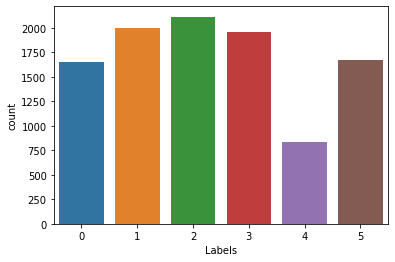

In [ ]:
sns.countplot(train_data['Labels'])

In [ ]:
if True in train_data.isnull():
  print("Data missing")
else:
  print("No missing data")

No missing data


In [ ]:
train_data.value_counts()

Labels  Text                                                                                                                        Text_Tag                     
1       On changing the rules for filibusters on presidential nominees                                                              congressional-rules              3
5       Says Mitt Romney flip-flopped on abortion.                                                                                  abortion,message-machine-2012    2
1       On repealing the 17th Amendment                                                                                             debates,elections,states         2
        On support for the Export-Import Bank                                                                                       trade                            2
        On the Trans-Pacific Partnership.                                                                                           trade                            2
   

In [ ]:
train_data[train_data.duplicated(['Text'])]

,Labels,Text,Text_Tag
1014,2,On abortion,"abortion,candidates-biography"
1814,1,On support for gay marriage.,"civil-rights,families,gays-and-lesbians,marriage"
1846,1,"Obama says Iran is a 'tiny' country, 'doesn't ...",foreign-policy
2697,1,On repealing the 17th Amendment,"debates,elections,states"
2846,3,"Four balanced budgets in a row, with no new ta...","job-accomplishments,jobs,state-budget,state-fi..."
3256,1,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment"
4386,1,On the Trans-Pacific Partnership.,trade
4839,2,During Sherrod Browns past decade as a D.C. po...,"economy,job-accomplishments,jobs"
4940,1,On changing the rules for filibusters on presi...,congressional-rules
6759,2,On torture.,"human-rights,terrorism"


In [ ]:
train_data['NewsText'] = train_data['Text_Tag'].astype(str) +" "+ train_data['Text']
test_data['NewsText'] = test_data['Text_Tag'].astype(str) +" "+ test_data['Text']

In [ ]:
train_data.head()

,Labels,Text,Text_Tag,NewsText
0,1,Says the Annies List political group supports ...,abortion,abortion Says the Annies List political group ...
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments","energy,history,job-accomplishments When did th..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,foreign-policy Hillary Clinton agrees with Joh...
3,1,Health care reform legislation is likely to ma...,health-care,health-care Health care reform legislation is ...
4,2,The economic turnaround started at the end of ...,"economy,jobs","economy,jobs The economic turnaround started a..."


(-0.5, 1299.5, 949.5, -0.5)

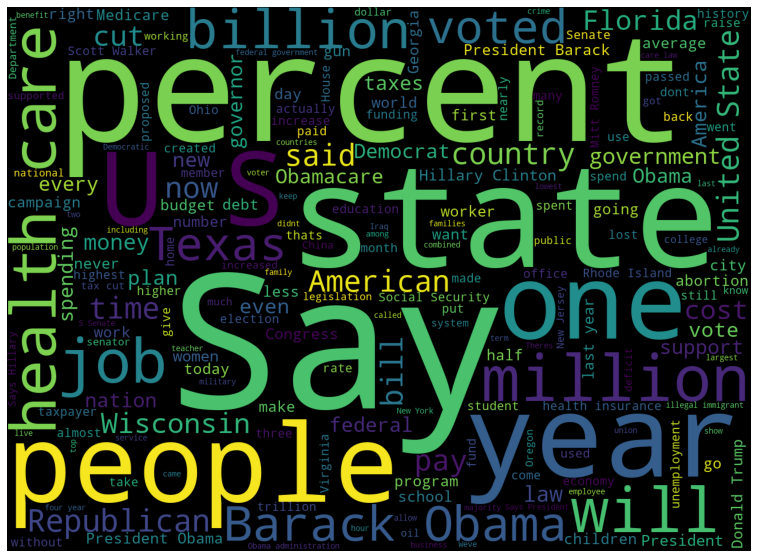

In [ ]:
train_qs = pd.Series(train_data['Text'].tolist()).astype(str)

from wordcloud import WordCloud
cloud = WordCloud(width=1300, height=950).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
class DataPreprocess:
    def __init__(self):
        self.filters = [strip_tags,
                       strip_numeric,
                       strip_punctuation,
                       lambda x: x.lower(),
                       lambda x: re.sub(r'\s+\w{1}\s+', '', x),
                       remove_stopwords]
    def __call__(self, doc):
        clean_words = self.__apply_filter(doc)
        return clean_words

    def __apply_filter(self, doc):
        try:
            cleanse_words = set(preprocess_string(doc, self.filters))
            filtered_words = set(wnl.lemmatize(w, 'v') for w in cleanse_words)
            return ' '.join(cleanse_words)
        except TypeError as te:
            raise(TypeError("Not a valid data {}".format(te)))

In [ ]:
wnl = WordNetLemmatizer()
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [ ]:
train_data['Processed'] = train_data['NewsText'].apply(DataPreprocess())
test_data['Processed'] = test_data['NewsText'].apply(DataPreprocess())

In [ ]:
test_data['Processed']

0       years border immigration thes buildingwall mex...
1          double pace jobs year number layoffs wisconsin
2       vets voting mccain veterans says john help mil...
3       message choice cut medicare machine bonamici a...
4       issues finance laws hes violate gov scott adve...
                              ...                        
1262    education state budget provides funding level ...
1263          criminal day ive civil crime justice rights
1264    foreign administrations soviet history biparti...
1265    permit strickland government environment langu...
1266    earners state budget income tax cut benefits g...
Name: Processed, Length: 1267, dtype: object

In [ ]:
X = train_data['Processed']
y = train_data['Labels']

y_category = keras.utils.to_categorical(y, 6)

X_train, X_valid, y_train, y_valid = train_test_split(X, y_category, shuffle=True, test_size=0.33, random_state=111)

print("Train shape : {}, Holdout shape: {}".format(X_train.shape, X_valid.shape))

Train shape : (6860,), Holdout shape: (3380,)


In [ ]:
def word_embedding(train, test, max_features, max_len=200):
    try:
        # Keras Tokenizer class object
        tokenizer = text.Tokenizer(num_words=max_features)
        tokenizer.fit_on_texts(train)

        train_data = tokenizer.texts_to_sequences(train)
        test_data = tokenizer.texts_to_sequences(test)

        # Get the max_len
        vocab_size = len(tokenizer.word_index) + 1

        # Padd the sequence based on the max-length
        x_train = sequence.pad_sequences(train_data, maxlen=max_len, padding='post')
        x_test = sequence.pad_sequences(test_data, maxlen=max_len, padding='post')
        # Return train, test and vocab size
        return tokenizer, x_train, x_test, vocab_size
    except ValueError as ve:
        raise(ValueError("Error in word embedding {}".format(ve)))


In [ ]:
max_features = 5000
max_len = 200
output_dim = len(np.unique(y))

# Test data
X_test = test_data['Processed']

tokenizer, x_pad_train, x_pad_valid, vocab_size = word_embedding(X_train, X_valid, max_features)

In [ ]:
# Test data
X_test = test_data['Processed']

tokenizer.fit_on_sequences(X_test)

X_test_seq = tokenizer.texts_to_sequences(X_test)
x_pad_test = sequence.pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
def compute_classweights(target):
    """
    Computes the weights of the target values based on the samples
    :param target: Y-target variable
    :return: dictionary object
    """
    # compute class weights
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes=np.unique(target), y=target)

    # make the class weight list into dictionary
    weights = {}

    # enumerate the list
    for index, weight in enumerate(class_weights):
        weights[index] = weight

    return weights

# Get the class weights for the target variable
weights = compute_classweights(y)

In [ ]:
weights

{0: 1.0318419991938734,
 1: 0.8554720133667502,
 2: 0.8073163040050457,
 3: 0.8698606863744478,
 4: 2.0341676599125944,
 5: 1.0182975338106603}

In [ ]:
def build_rnn(vocab_size, output_dim, max_len):
    # Building RNN model
    model = Sequential([
        keras.layers.Embedding(vocab_size,128,
                              input_length=max_len),
        keras.layers.BatchNormalization(),
#         keras.layers.Bidirectional(keras.layers.LSTM(128,return_sequences=True)),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)),
        keras.layers.GlobalMaxPool1D(), # Remove flatten layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(output_dim, activation='softmax')
    ])

    return model

In [ ]:
X_train.shape

(6860,)

In [ ]:
rnn_model = build_rnn(vocab_size, output_dim, max_len)

# Summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1528192   
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 200, 128)          16512     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0

In [ ]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.metrics.AUC()])

In [ ]:
history = rnn_model.fit(x_pad_train, y_train, batch_size=512,
                        epochs=20, verbose=1, validation_data=(x_pad_valid, y_valid),
                        class_weight=weights)

Epoch 1/20
14/14 [==============================] - 10s 582ms/step - loss: 2.5452 - auc: 0.5095 - val_loss: 2.2818 - val_auc: 0.4609
Epoch 2/20
14/14 [==============================] - 8s 540ms/step - loss: 2.2610 - auc: 0.5401 - val_loss: 2.2610 - val_auc: 0.4616
Epoch 3/20
14/14 [==============================] - 8s 547ms/step - loss: 2.1965 - auc: 0.6100 - val_loss: 2.2414 - val_auc: 0.4587
Epoch 4/20
14/14 [==============================] - 8s 600ms/step - loss: 2.1261 - auc: 0.6547 - val_loss: 2.2228 - val_auc: 0.4741
Epoch 5/20
14/14 [==============================] - 8s 564ms/step - loss: 2.0401 - auc: 0.6993 - val_loss: 2.2074 - val_auc: 0.4717
Epoch 6/20
14/14 [==============================] - 8s 545ms/step - loss: 1.9367 - auc: 0.7409 - val_loss: 2.1918 - val_auc: 0.5080
Epoch 7/20
14/14 [==============================] - 8s 551ms/step - loss: 1.8402 - auc: 0.7725 - val_loss: 2.1781 - val_auc: 0.5263
Epoch 8/20
14/14 [==============================] - 8s 542ms/step - loss: 1

In [ ]:
results = rnn_model.evaluate(x_pad_valid, y_valid)

106/106 [==============================] - 1s 11ms/step - loss: 2.1071 - auc: 0.5693


In [ ]:
results

[2.107125997543335, 0.5692976713180542]

In [ ]:
results = rnn_model.evaluate(x_pad_valid, y_valid)
print("Model Validation: \n%s : %0.2f%%" % (rnn_model.metrics_names[1], results[1]*100))

106/106 [==============================] - 2s 19ms/step - loss: 2.1071 - auc: 0.5693
Model Validation: 
auc : 56.93%


In [ ]:
x_pad_test.shape

(1267, 200)

In [ ]:
y_preds = rnn_model.predict(x_pad_test, batch_size=256)

5/5 [==============================] - 0s 60ms/step


In [ ]:
y_preds.shape

(1267, 6)

In [ ]:
final_df = pd.DataFrame({'0': y_preds[:,0],
                        '1': y_preds[:,1],
                        '2': y_preds[:,2],
                        '3': y_preds[:,3],
                        '4': y_preds[:,4],
                        '5': y_preds[:,5]}, index=test_data.index)

In [ ]:
final_df

,0,1,2,3,4,5
0,0.126748,0.139630,0.200755,0.291797,0.131323,0.109747
1,0.118459,0.333694,0.155850,0.062866,0.166666,0.162466
2,0.172078,0.159918,0.148932,0.134976,0.116537,0.267558
3,0.116351,0.236344,0.201198,0.115621,0.123563,0.206923
4,0.110397,0.402950,0.202995,0.062922,0.112251,0.108486
...,...,...,...,...,...,...
1262,0.338579,0.130563,0.135752,0.161986,0.102964,0.130157
1263,0.155617,0.128623,0.131310,0.188214,0.161858,0.234378
1264,0.127132,0.112465,0.152249,0.215566,0.115724,0.276865
1265,0.186493,0.105321,0.162821,0.252634,0.102986,0.189745
